# Problem Description

Companies like Netflix, Youtube, Amazon etc., leverage reccomedation systems to help users discover new and relevant items (movies, videos, music, products), creating a delightful user experience while driving incremental revenue.

Most recommender systems are typically classified into two broad categories- 
1. Contend Based
2. Collaborative filtering

However, complex algorithms can implement both approaches. Content-based methods leverge similarity of item attributes while collaborative based approach make used of similarity among users/interactions.

Here we implement a recommender system for restaurants using user-based collaborative filtering approach. Food application companies such as Hungrygowhere, Zomato, Grab can leverage such system to provide explicit range of restaurants based on customer's previous choices and interests.

# Data Description

Here I have use Toronto neighborhood data with geolocation information, which I scraped from wikipedia in the last week's assignment. I am using only those neighborhood areas which are inside Boroughs containing 'Toronto' in it. 

For all these neighborhoods, I extracted nearby Restaurants within the radius of 5kms using Foursquare api. So, we hve in total 20 restaurants. I also created unique ids for each restaurant for later reference using uuid.
Restaurant data comprise of : Restaurant id, Category, Geolocation, Neighborhood information.

For rating data, I used a random dataset of 1000 users who provided 5- star ratings to these restaurants.

Rating data comprise of User Id, Restarant id, rating and timestamp information.

# Implementation

## Import libraries

In [87]:
import numpy as np 
import pandas as pd 
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Load dataset

In [88]:
users = pd.read_csv(r'data\rating.csv')
restaurants = pd.read_csv(r'data\restaurants.csv')

In [89]:
restaurants.loc[12,:]

Unnamed: 0                                                  12
Neighborhood                         Regent Park, Harbourfront
Neighborhood Latitude                                  43.6543
Neighborhood Longitude                                -79.3606
Venue                                   Rol San Restaurant 龍笙棧
Venue Latitude                                         43.6543
Venue Longitude                                       -79.3986
categories                                  Dim Sum Restaurant
Id                        7c0e3d24-2e32-4bf9-8035-d83912896a5d
Name: 12, dtype: object

In [90]:
#Clean Venue column and remove unwanted characters
restaurants['Venue'] = restaurants['Venue'].str.replace('[^a-zA-Z.*\s]', '')

## Exploratory analysis

In [91]:
#Join restaurant id with user table

df_rest = restaurants[['Id', 'Venue']].set_index('Id')

df = users.join(df_rest, how = 'left', on = 'restaurant_id')

In [92]:
df_users = users[['userId','restaurant_id', 'rating', 'timestamp']]

In [93]:
train_data, test_data = train_test_split(df_users, test_size = 0.2)

In [94]:
n_users = train_data.userId.unique().shape[0]
n_items = train_data.restaurant_id.unique().shape[0]

print('Number of unique users: {}'.format(n_users))
print('Number of unique venues: {}'.format(n_items))

Number of unique users: 791
Number of unique venues: 20


In [95]:
avg_num_reviews = train_data.groupby('userId')['rating'].count()
print("Avg Number of ratings per reviewer {}".format(avg_num_reviews.mean()))

Avg Number of ratings per reviewer 1.011378002528445


Text(0, 0.5, 'number of reviewers')

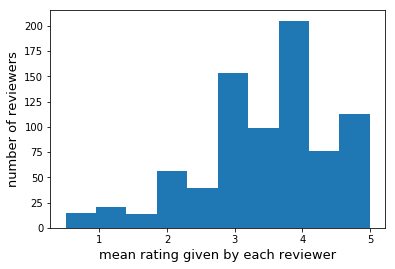

In [96]:
mean_rating_of_user = train_data.groupby('userId').apply(lambda x: x['rating'].mean())

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

## Create user-item matrix

In [97]:
#create a user-item matrix which can be used to calculate the similarity between users and items.
train_rating_matrix = train_data.pivot_table(index='userId', columns='restaurant_id', values='rating')
test_rating_matrix = test_data.pivot_table(index='userId', columns='restaurant_id', values='rating')

train_rating_matrix.head()



restaurant_id,3a6eaef3-8cd8-411f-8e25-1badf8eac70a,4593135c-d4cb-4109-8ec8-8bb8552defa1,47566a74-7f4a-48cc-8e8b-1aefcfca6ff0,4c872944-34db-4dce-b725-4b3b4c941943,4f8e488c-cba3-48f2-a1b0-c3104adb8710,51fd086f-22ec-4688-bef9-136a9aa67fa5,7340d575-7000-4dcf-b651-7c7fcb84db2a,7c0e3d24-2e32-4bf9-8035-d83912896a5d,9a7fb283-c645-4c15-8a0d-f6d8e02d511a,a1d32461-3e7c-4158-9cd6-f3cd22a79ca4,a6f9ed8e-bdea-4226-9aaa-c8f2756d1eda,a701267d-e2a8-4732-add7-fdd7b235d7df,b1827b90-186c-4c7d-8853-a7c07cde5129,c0f1a93f-c24c-410a-9437-ba573de83b7b,cc46c000-4ae5-463e-a2ba-9d4217622b88,e150bd06-feb4-4453-9ff0-6f633b4d2dcd,e23816a3-c3ee-476d-8a6f-b76300d94576,e261ec34-1ae9-4d99-a963-62af7f3eaaf0,f0af355c-7a46-4f9f-b103-580b3e455b0e,f4d5566e-0e3b-41ca-b9a7-efc027faa0f3
userId,,,,,,,,,,,,,,,,,,,,
256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1220,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1281,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate user-user and item-item similarity

A distance metric commonly used in recommender systems is cosine similarity, where the ratings are seen as vectors in n-dimensional space and the similarity is calculated based on the angle between these vectors. Cosine similarity for users a and m can be calculated using the formula below, where you take dot product of the user vector uk“>𝑢𝑘uk and the user vector ua“>𝑢𝑎ua and divide it by multiplication of the Euclidean lengths of the vectors.

In [98]:
#Calculate cosine similarity 

from sklearn.metrics import pairwise_distances

user_similarity = pairwise_distances(train_rating_matrix.fillna(0), metric = 'cosine')
item_similarity = pairwise_distances(train_rating_matrix.fillna(0).T, metric = 'cosine')

## Make Predictions

You can look at the similarity between users k and a as weights that are multiplied by the ratings of a similar user a (corrected for the average rating of that user). You will need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict.
The idea here is that certain users may tend always to give high or low ratings to all restaurants. The relative difference in the ratings that these users give is more important than the absolute rating values. 

In [99]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [115]:
user_prediction = predict(train_rating_matrix, user_similarity, type='user')
item_prediction = predict(train_rating_matrix, item_similarity, type='item')

## Evaluation

In [116]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[np.nonzero(ground_truth)].flatten()
    ground_truth = ground_truth[np.nonzero(ground_truth)].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

## Discussion

This method also called Memory-based algorithms are easy to implement and produce reasonable prediction quality. The drawback of memory-based CF is that it doesn’t scale to real-world scenarios and doesn’t address the well-known cold-start problem, that is when a new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don’t have any ratings enter the system.